<a href="https://colab.research.google.com/github/Colossus08/ML-Assignment-2/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning: Assignment 2**
Veronica Morales (*s4002620*) \
Aaron Thomas (*s4109199*)

# 1. Approach

## 1.1 Data Exploration and Understanding

The initial phase involved exploring the dataset of 9896 image patches from 60 patients to understand its characteristics, identify issues like class imbalance, and gather insights for modeling. The dataset was found to be clean with no missing values.


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ML_A-2/Image_classification_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: patch_images/2445.png   
  inflating: patch_images/19898.png  
  inflating: patch_images/10102.png  
  inflating: patch_images/1164.png   
  inflating: patch_images/9538.png   
  inflating: patch_images/7515.png   
  inflating: patch_images/11234.png  
  inflating: patch_images/3773.png   
  inflating: patch_images/19668.png  
  inflating: patch_images/5302.png   
  inflating: patch_images/18576.png  
  inflating: patch_images/17645.png  
  inflating: patch_images/5464.png   
  inflating: patch_images/18210.png  
  inflating: patch_images/17123.png  
  inflating: patch_images/10894.png  
  inflating: patch_images/21491.png  
  inflating: patch_images/11552.png  
  inflating: patch_images/20957.png  
  inflating: patch_images/3015.png   
  inflating: patch_images/22198.png  
  inflating: patch_images/15734.png  
  inflating: patch_images/8140.png   
  inflating: patch_images/7273.png   
  inflating: patch_images/396.png    

In [ ]:
!unzip '/content/Image_classification_data.zip'

unzip:  cannot find or open /content/Image_classification_data.zip, /content/Image_classification_data.zip.zip or /content/Image_classification_data.zip.ZIP.


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df=pd.read_csv('/content/data_labels_mainData.csv')

In [ ]:
df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [ ]:
df.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [ ]:
df.isnull().sum()

,0
InstanceID,0
patientID,0
ImageName,0
cellTypeName,0
cellType,0
isCancerous,0


In [ ]:
df.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [ ]:
len(df.value_counts('patientID'))

60

In [ ]:
df.value_counts('cellTypeName')

,count
cellTypeName,
epithelial,4079
inflammatory,2543
fibroblast,1888
others,1386


In [ ]:
df.value_counts('cellType')

,count
cellType,
2,4079
1,2543
0,1888
3,1386


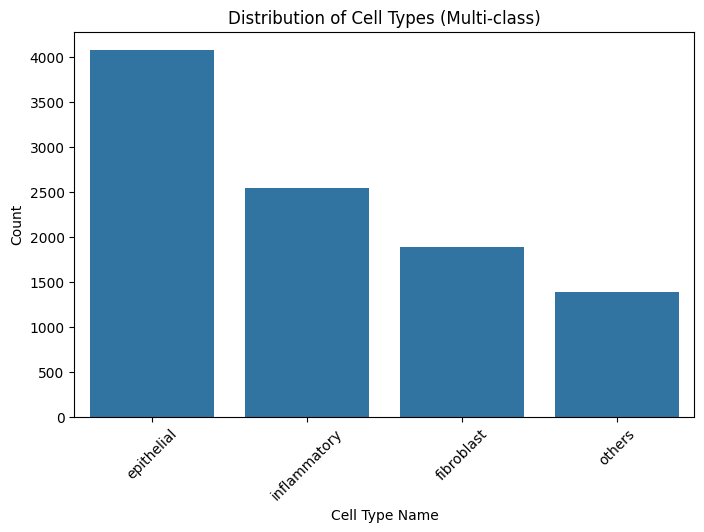

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='cellTypeName', order=df['cellTypeName'].value_counts().index)
plt.title('Distribution of Cell Types (Multi-class)')
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.value_counts('isCancerous')

,count
isCancerous,
0,5817
1,4079


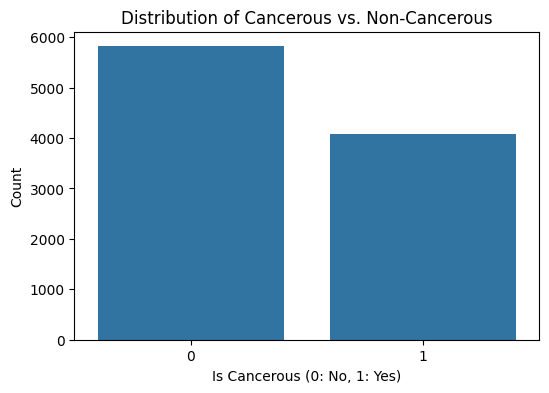

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='isCancerous')
plt.title('Distribution of Cancerous vs. Non-Cancerous')
plt.xlabel('Is Cancerous (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

#### Class Imbalance Identification
##### Implications of Class Imbalance
Class imbalance is a critical issue as it can lead to biased model performance and poor generalisation, especially for minority classes.

* **Multi-class Imbalance (`cellTypeName`):** The dataset showed notable imbalance. 'Epithelial cells' (4079 instances) were the most frequent, followed by 'Inflammatory cells' (2543), 'Fibroblast' (1888), and 'Others' (1386). The ratio between the most and least frequent class was approximately 2.94, indicating a significant imbalance that required attention during modeling.

* **Binary Class Imbalance (`isCancerous`):** A moderate imbalance was observed, with non-cancerous samples (5817 instances, labeled 0) outnumbering cancerous samples (4079 instances, labeled 1). The ratio was approximately 1.43, also warranting consideration.


isCancerous      0     1
cellTypeName            
epithelial       0  4079
fibroblast    1888     0
inflammatory  2543     0
others        1386     0


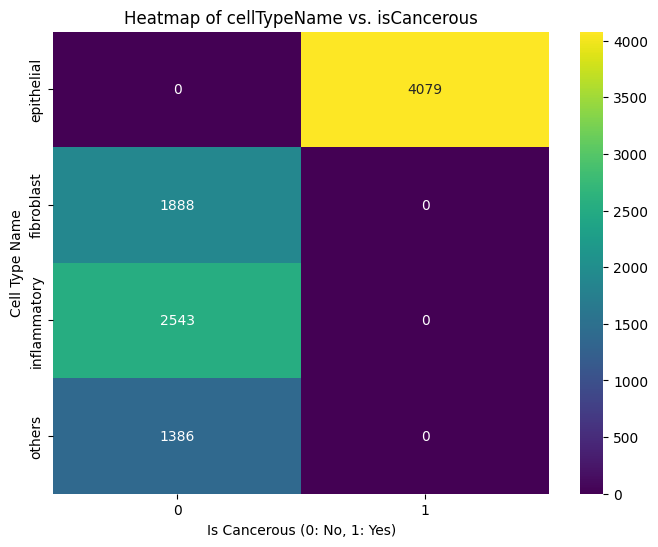

In [ ]:
crosstab_ct_cancer = pd.crosstab(df['cellTypeName'], df['isCancerous'])
print(crosstab_ct_cancer)

plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_ct_cancer, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of cellTypeName vs. isCancerous')
plt.xlabel('Is Cancerous (0: No, 1: Yes)')
plt.ylabel('Cell Type Name')
plt.show()

#### Relationship Between Cell Type and Cancer Status

A crucial finding from the EDA was a perfect correlation within this dataset: all 4079 'Epithelial' cell samples were labeled as cancerous, while all 5817 samples from 'Fibroblast', 'Inflammatory', and 'Others' cell types were labeled non-cancerous. This implies the binary classification task is effectively distinguishing epithelial cells from the others in this specific dataset. This strong link is a critical consideration for model interpretation and generalisation.


## 1.2 Evaluation Framework


Appropriate performance metrics are essential, especially in medical image analysis where class imbalance is common and misclassification costs are high.

### Binary Classification Metrics (`isCancerous`)

Key metrics include:

1. ***Accuracy*** - Overall correctness, but can be misleading with imbalance.

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$


2. ***Precision*** - Proportion of positive predictions that were actually positive; important for minimising false alarms (e.g., false cancer diagnoses).

$$
\frac{TP}{TP + FP}
$$


3. ***Recall or Sensitivity*** - Proportion of actual positives correctly identified; often the most important in cancer detection to minimise missed diagnoses.
    

$$
\frac{TP}{TP + FN}
$$


4. ***F1-Score*** - Harmonic mean of precision and recall, useful for balancing their trade-offs, especially with imbalanced classes.


$$
\frac{Precision × Recall}{Precision + Recall} × 2
$$


5. ***Specificity*** - Proportion of actual negatives correctly identified; complements recall by ensuring non-cancerous cases are correctly identified.


$$
\frac{TN}{TN + FP}
$$


6. ***AUC-ROC (Area Under the Receiver Operating Characteristic Curve)*** - Measures the model's ability to distinguish between classes across all thresholds, strong against class imbalance (Marcus, 2019).


### Multi-class Classifcation (*cellTypeName*)

In addition to Accuracy, Precision, Recall, and F1-Score (calculated per class), the following are important:

* **Macro-Average Precision, Recall, and F1-Score:** These calculate the metric for each class independently and then average them, giving equal weight to each class. This is important for fairly evaluating performance on imbalanced multi-class datasets, ensuring the model performs well across all cell types, including minority ones (Leung, n.d.).

## 1.3 Model Selection and Justification

### Base Model Selection

Convolutional Neural Networks (**CNNs**) were chosen as the primary model architecture. Unlike Multilayer Perceptrons (**MLPs**), which require flattened input and thus lose essential spatial relationships within images, CNNs are designed to process grid-like data. They use convolutional layers to automatically learn hierarchical spatial features like edges, textures and complex patterns directly from pixel data. This makes CNNs more suitable and effective for image classification tasks such as distinguishing cell types or identifying cancerous tissues, where such spatial information is important (Uniqtech, 2021; Litjens et al., 2017).

For each of the multi-class and binary classification, a baseline CNN model (Dutta, 2024) was established and then systematically optimised, as detailed in the next section (1.4).



### Data Splitting and Leakage Prevention
A key consideration in medical image datasets derived from multiple patients is preventing data leakage, where information from the validation set inadvertently influences training. For both models, `GroupShuffleSplit` was employed. This method ensures that all image patches from a single patient are assigned to either the training or the validation set, but not both. This patient-aware splitting provides a more realistic estimate of model performance on unseen patients.


### Multi-class Classification Baseline Model

In [ ]:
from sklearn.model_selection import train_test_split
train_df,val_df=train_test_split(df[['ImageName','cellTypeName','cellType']],test_size=0.2,stratify=df['cellType'],random_state=42)

In [309]:
# from sklearn.model_selection import train_test_split
# train_df,val_df=train_test_split(df[['ImageName','cellTypeName','cellType']],test_size=0.2,stratify=df['cellType'],random_state=42)

# # from sklearn.model_selection import GroupShuffleSplit


# #X_bin = df[['ImageName', 'cellTypeName','cellType','patientID']]
# #y_bin = df['cellType']
# #groups_bin = df['patientID']


# gss_bin = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# train_idx_bin, val_idx_bin = next(gss_bin.split(X_bin, y_bin, groups_bin))


# train_df = df.iloc[train_idx_bin][['ImageName', 'isCancerous', 'patientID']].copy()
# val_df = df.iloc[val_idx_bin][['ImageName', 'isCancerous', 'patientID']].copy()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


training_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')
validation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [ ]:
batch_size=32

In [ ]:
training_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='sparse'
)


validation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

basemodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
basemodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
basehistory=basemodel.fit(training_generator,epochs=30,validation_data=validation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1.2704 - sparse_categorical_accuracy: 0.4583 - val_loss: 1.0183 - val_sparse_categorical_accuracy: 0.6247
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9338 - sparse_categorical_accuracy: 0.6485 - val_loss: 0.7891 - val_sparse_categorical_accuracy: 0.7071
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8432 - sparse_categorical_accuracy: 0.6879 - val_loss: 0.7557 - val_sparse_categorical_accuracy: 0.7162
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.8116 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.7374
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7820 - sparse_categorical_accuracy: 0.7074 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.7328
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.7867 - sparse_categorical_accuracy: 0.7094 - val_loss: 0.8273 - val_sparse_categorical_accuracy: 0.6869
Epoch 7/

In [ ]:
basemodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

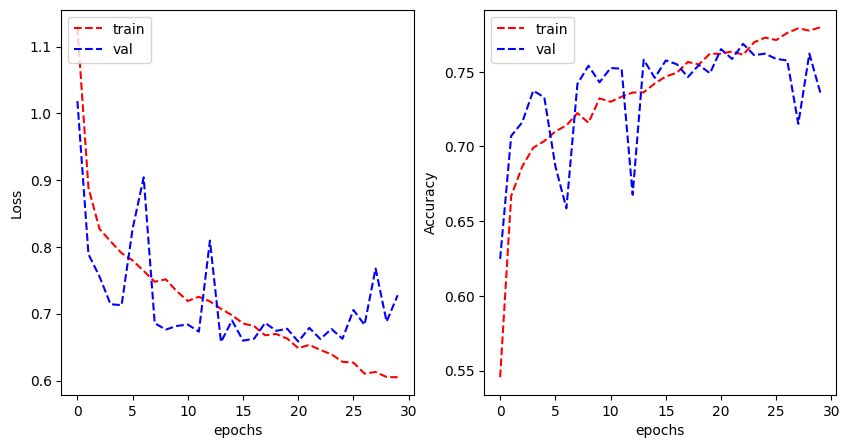

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(basehistory.history['loss'], 'r--')
plt.plot(basehistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(basehistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(basehistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Increasing number of layers

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

incmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
incmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
inchistory=incmodel.fit(training_generator,epochs=30,validation_data=validation_generator)

Epoch 1/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 1.3476 - sparse_categorical_accuracy: 0.4019 - val_loss: 0.9449 - val_sparse_categorical_accuracy: 0.6253
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.9466 - sparse_categorical_accuracy: 0.6643 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.7020
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9100 - sparse_categorical_accuracy: 0.6610 - val_loss: 0.9077 - val_sparse_categorical_accuracy: 0.6475
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8908 - sparse_categorical_accuracy: 0.6788 - val_loss: 0.7517 - val_sparse_categorical_accuracy: 0.7222
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8514 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.8167 - val_sparse_categorical_accuracy: 0.6874
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.8152 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.8400 - val_sparse_categorical_accuracy: 0.6

In [ ]:
incmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,526 (1.12 MB)

 Trainable params: 97,508 (380.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 195,018 (761.79 KB)

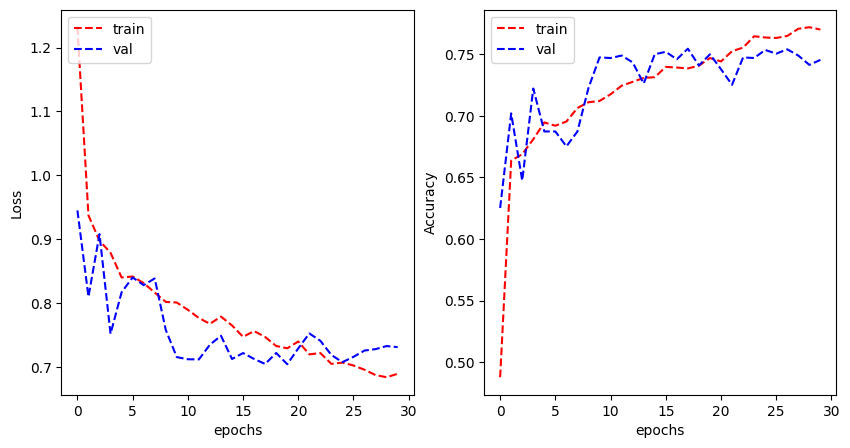

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(inchistory.history['loss'], 'r--')
plt.plot(inchistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(inchistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(inchistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Changing Dropout value

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

dropmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
dropmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
drophistory=dropmodel.fit(training_generator,epochs=40,validation_data=validation_generator)

Epoch 1/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 1.3099 - sparse_categorical_accuracy: 0.4203 - val_loss: 0.9067 - val_sparse_categorical_accuracy: 0.6712
Epoch 2/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.0084 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.7908 - val_sparse_categorical_accuracy: 0.7010
Epoch 3/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9349 - sparse_categorical_accuracy: 0.6589 - val_loss: 0.7668 - val_sparse_categorical_accuracy: 0.7010
Epoch 4/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8911 - sparse_categorical_accuracy: 0.6702 - val_loss: 0.7554 - val_sparse_categorical_accuracy: 0.7141
Epoch 5/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.8495 - sparse_categorical_accuracy: 0.6903 - val_loss: 0.7435 - val_sparse_categorical_accuracy: 0.7207
Epoch 6/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8558 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.718

In [ ]:
dropmodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

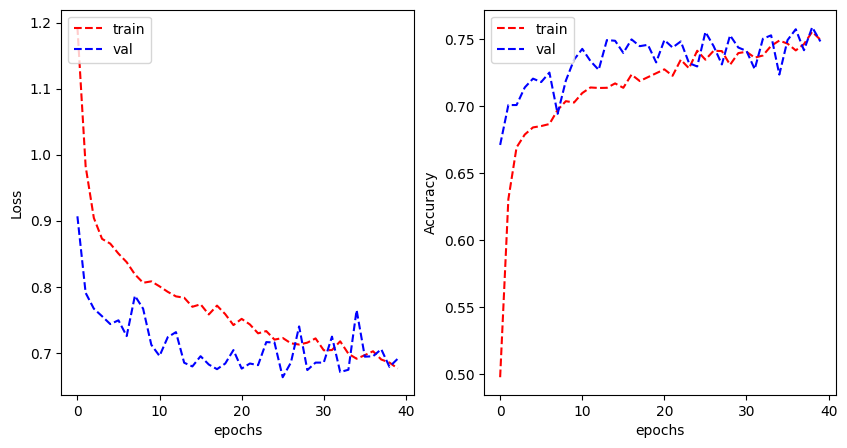

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(drophistory.history['loss'], 'r--')
plt.plot(drophistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(drophistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(drophistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Grayscaling images

In [ ]:
graytraining_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    color_mode='grayscale'
)


grayvalidation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

graymodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,1)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
graymodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
grayhistory=graymodel.fit(graytraining_generator,epochs=30,validation_data=grayvalidation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 1.3746 - sparse_categorical_accuracy: 0.3857 - val_loss: 1.2760 - val_sparse_categorical_accuracy: 0.4348
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.4962 - val_loss: 1.0491 - val_sparse_categorical_accuracy: 0.5869
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1.0597 - sparse_categorical_accuracy: 0.5866 - val_loss: 0.9791 - val_sparse_categorical_accuracy: 0.5975
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.0382 - sparse_categorical_accuracy: 0.5898 - val_loss: 0.9427 - val_sparse_categorical_accuracy: 0.6313
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.0188 - sparse_categorical_accuracy: 0.5996 - val_loss: 0.9172 - val_sparse_categorical_accuracy: 0.6429
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9756 - sparse_categorical_accuracy: 0.6140 - val_loss: 0.9101 - val_sparse_categorical_accuracy: 0.6449
Epoch 7/30
62/62 ━

In [ ]:
graymodel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,622 (1.39 MB)

 Trainable params: 121,540 (474.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,082 (949.54 KB)

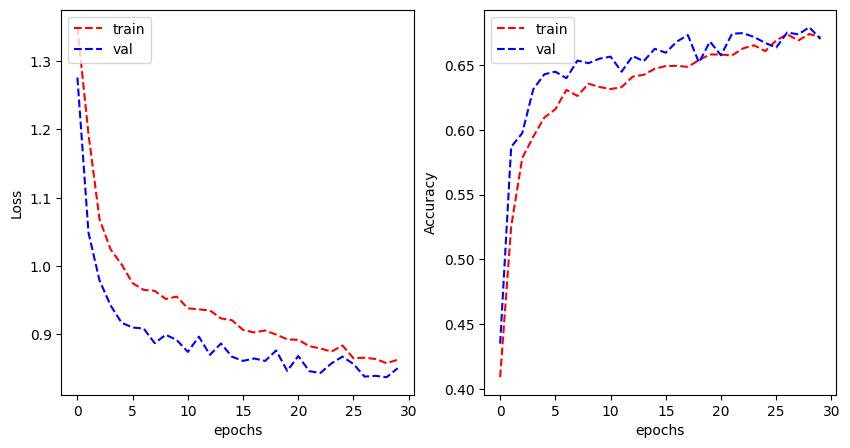

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(grayhistory.history['loss'], 'r--')
plt.plot(grayhistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(grayhistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(grayhistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Batch Normalization

In [ ]:
batchtraining_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)


batchvalidation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

batchmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
batchmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
batchhistory=batchmodel.fit(batchtraining_generator,epochs=30,validation_data=batchvalidation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 1.2186 - sparse_categorical_accuracy: 0.5191 - val_loss: 1.2592 - val_sparse_categorical_accuracy: 0.5136
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.8344 - sparse_categorical_accuracy: 0.6904 - val_loss: 1.0654 - val_sparse_categorical_accuracy: 0.5076
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.7834 - sparse_categorical_accuracy: 0.7099 - val_loss: 1.1459 - val_sparse_categorical_accuracy: 0.5677
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.7597 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.7222
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.7162 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.7519 - val_sparse_categorical_accuracy: 0.7288
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.7715 - val_sparse_categorical_accuracy: 0.7167
Epoch 7/30
62/62 ━━

In [ ]:
batchmodel.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,862 (1.40 MB)

 Trainable params: 122,244 (477.52 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 244,490 (955.04 KB)

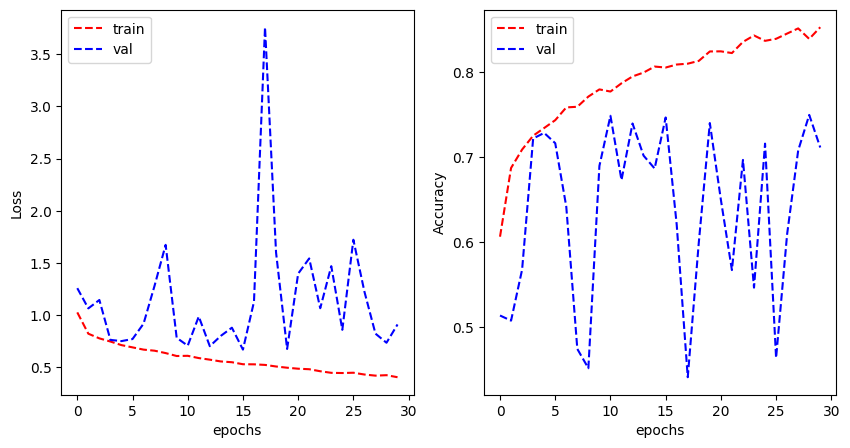

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(batchhistory.history['loss'], 'r--')
plt.plot(batchhistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(batchhistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(batchhistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Data Augmentation

In [ ]:
aug_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
  )

aug_val_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last'
  )

In [ ]:
augtraining_generator=aug_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)


augvalidation_generator=aug_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    shuffle=False
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

augmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
augmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
aughistory=augmodel.fit(augtraining_generator,epochs=30,validation_data=augvalidation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 1.3634 - sparse_categorical_accuracy: 0.4064 - val_loss: 1.1134 - val_sparse_categorical_accuracy: 0.6217
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 1.1058 - sparse_categorical_accuracy: 0.5544 - val_loss: 0.9517 - val_sparse_categorical_accuracy: 0.6662
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.6314 - val_loss: 0.8723 - val_sparse_categorical_accuracy: 0.6747
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.8888 - sparse_categorical_accuracy: 0.6670 - val_loss: 0.7934 - val_sparse_categorical_accuracy: 0.7040
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.8900 - sparse_categorical_accuracy: 0.6662 - val_loss: 0.7853 - val_sparse_categorical_accuracy: 0.7096
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.8484 - sparse_categorical_accuracy: 0.6806 - val_loss: 0.8180 - val_sparse_categorical_accuracy: 0.6899
Epoch

In [ ]:
augmodel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

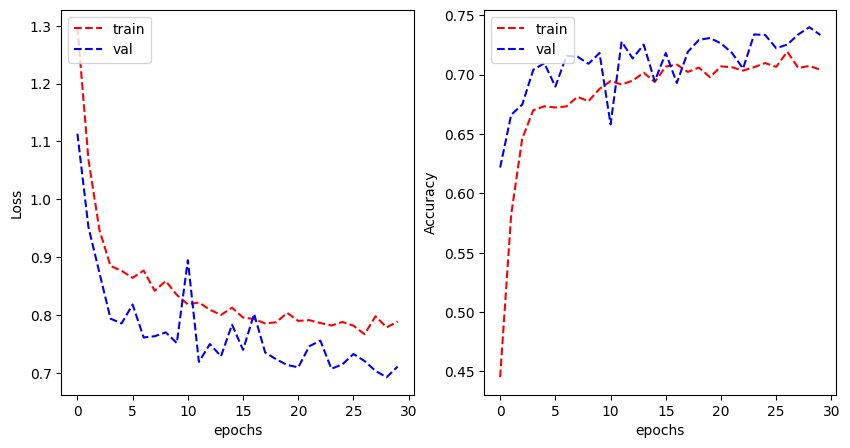

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(aughistory.history['loss'], 'r--')
plt.plot(aughistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(aughistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(aughistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Sampling imbalanced classes

In [ ]:
from sklearn.utils import class_weight
classes=np.unique(train_df['cellType'].values)
weights=class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['cellType'].values
)

weight_dict=dict(zip(classes,weights))

In [ ]:
sampletraining_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)
samplevalidation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [ ]:
sampletraining_generator=sampletraining_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=64,
    class_mode='sparse',
)


samplevalidation_generator=samplevalidation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=64,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
areg_lambda = 0.0005
OUTPUT_CLASSES = 4

samplemodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(128),

    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
samplemodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
samplehistory=samplemodel.fit(sampletraining_generator,epochs=30,validation_data=samplevalidation_generator,class_weight=weight_dict)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - loss: 1.5887 - sparse_categorical_accuracy: 0.3863 - val_loss: 0.9706 - val_sparse_categorical_accuracy: 0.5939
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 1.0451 - sparse_categorical_accuracy: 0.5852 - val_loss: 1.0466 - val_sparse_categorical_accuracy: 0.5162
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.9353 - sparse_categorical_accuracy: 0.6209 - val_loss: 0.8273 - val_sparse_categorical_accuracy: 0.6934
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.8788 - sparse_categorical_accuracy: 0.6556 - val_loss: 0.7843 - val_sparse_categorical_accuracy: 0.6990
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.8657 - sparse_categorical_accuracy: 0.6569 - val_loss: 0.7917 - val_sparse_categorical_accuracy: 0.6778
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.8450 - sparse_categorical_accuracy: 0.6759 - val_loss: 0.7705 - val_sparse_categorical_accuracy: 0.7040
Epoch 7/

In [ ]:
samplemodel.summary()

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(samplehistory.history['loss'], 'r--')
plt.plot(samplehistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(samplehistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(samplehistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Binary Classification Baseline Model

In [241]:
from sklearn.model_selection import train_test_split
bin_train_df,bin_val_df=train_test_split(df[['ImageName','isCancerous']],test_size=0.2,stratify=df['isCancerous'],random_state=42)

In [242]:
from sklearn.model_selection import GroupShuffleSplit


X_bin = df[['ImageName', 'isCancerous', 'patientID']]
y_bin = df['isCancerous']
groups_bin = df['patientID']


gss_bin = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx_bin, val_idx_bin = next(gss_bin.split(X_bin, y_bin, groups_bin))


bin_train_df = df.iloc[train_idx_bin][['ImageName', 'isCancerous', 'patientID']].copy()
bin_val_df = df.iloc[val_idx_bin][['ImageName', 'isCancerous', 'patientID']].copy()

In [243]:
bin_train_df['isCancerous']=bin_train_df['isCancerous'].astype(str)
bin_val_df['isCancerous']=bin_val_df['isCancerous'].astype(str)

In [244]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


bin_training_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')
bin_validation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [245]:
bin_batch_size=32

In [246]:
bin_training_generator=bin_training_datagen.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb'
)


bin_validation_generator=bin_validation_datagen.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=bin_batch_size,
    class_mode='binary',
    shuffle=False
)


Found 8057 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.


In [247]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [248]:
early_stopping_bin = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

checkpoint_dir_bin = './model_checkpoints_bin'
if not os.path.exists(checkpoint_dir_bin):
    os.makedirs(checkpoint_dir_bin)

In [249]:
model_checkpoint_bin = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_bin, 'best_bin_model_opt_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [250]:
reduce_lr_bin = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks_list_bin = [early_stopping_bin, model_checkpoint_bin, reduce_lr_bin]

epochs_bin = 50

steps_per_epoch_bin = len(bin_training_generator)
validation_steps_bin = len(bin_validation_generator)

In [251]:
reg_lambda = 0.001

bin_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [252]:
bin_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [253]:
bin_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,921 (476.25 KB)

 Trainable params: 121,921 (476.25 KB)

 Non-trainable params: 0 (0.00 B)

In [254]:
bin_history = bin_model.fit(
    bin_training_generator,
    epochs=epochs_bin,
    validation_data=bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6932 - loss: 0.6010
Epoch 1: val_accuracy improved from -inf to 0.86841, saving model to ./model_checkpoints_bin/best_bin_model_opt_epoch_01_val_acc_0.8684.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6943 - loss: 0.5996 - val_accuracy: 0.8684 - val_loss: 0.3548 - learning_rate: 0.0010
Epoch 2/50
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8503 - loss: 0.3827
Epoch 2: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8504 - loss: 0.3826 - val_accuracy: 0.8244 - val_loss: 0.4361 - learning_rate: 0.0010
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8800 - loss: 0.3178
Epoch 3: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8800 - loss: 0.3178 - val_accuracy: 0.8662 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 4/50
249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8909 - loss: 0

In [255]:
import matplotlib.pyplot as plt

In [256]:
bin_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [257]:
def plot_training_history(history, model_name="Model"):

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'b--', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([0.78, 0.94])
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'r--', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b--', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim([0.18, 0.5])
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

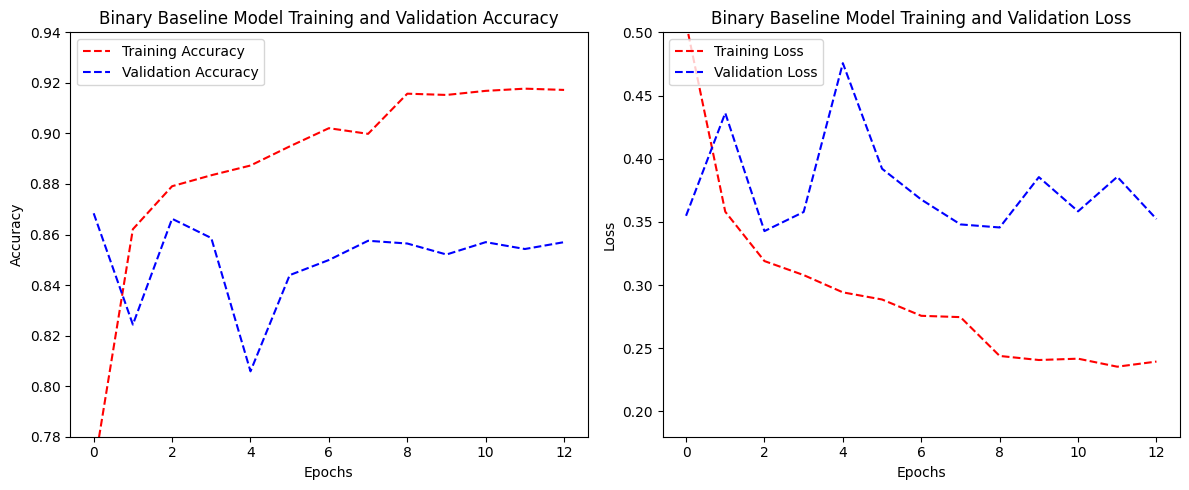

In [258]:
plot_training_history(bin_history, model_name= "Binary Baseline Model")

#### Addressing Class Imbalance

In [259]:
import matplotlib.pyplot as plt

In [260]:
import numpy as np

In [261]:
class_labels_binary = np.unique(bin_training_generator.classes)

In [262]:
from sklearn.utils import class_weight

In [263]:
class_labels_binary = np.unique(bin_training_generator.classes)
y_train_binary = bin_training_generator.classes

class_weights_binary_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels_binary,
    y=y_train_binary
)

class_weight_dict_binary = dict(zip(class_labels_binary, class_weights_binary_arr))

print(f"Binary Class Labels: {class_labels_binary}")
print(f"Binary Class Weights: {class_weight_dict_binary}")

Binary Class Labels: [0 1]
Binary Class Weights: {np.int64(0): np.float64(0.8216398123597797), np.int64(1): np.float64(1.2772669625871909)}


#### Batch Normalisation

In [264]:
batch_bin_training_generator=bin_training_datagen.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=128,
    class_mode='binary'
)


batch_bin_validation_generator=bin_validation_datagen.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=128,
    class_mode='binary'
)

Found 8057 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.


In [265]:
reg_lambda = 0.001

bin_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [266]:
bin_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [267]:
bin_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,001 (93.75 KB)

 Trainable params: 23,809 (93.00 KB)

 Non-trainable params: 192 (768.00 B)

In [268]:
bin_normalized = bin_model.fit(
    batch_bin_training_generator,
    epochs=epochs_bin,
    validation_data=batch_bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin,
    class_weight=class_weight_dict_binary,
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 62/252 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8220 - loss: 0.4485

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8521 - loss: 0.3915 - val_accuracy: 0.4992 - val_loss: 0.7343 - learning_rate: 0.0010
Epoch 2/50
 63/252 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8944 - loss: 0.3086
Epoch 2: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8939 - loss: 0.3023 - val_accuracy: 0.8564 - val_loss: 0.6206 - learning_rate: 0.0010
Epoch 3/50
 63/252 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9030 - loss: 0.2816
Epoch 3: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8982 - loss: 0.2866 - val_accuracy: 0.5617 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 4/50
 63/252 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8967 - loss: 0.2848
Epoch 4: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9029 - loss: 0.2721 - val_accuracy: 0.5073 - val_loss:

In [269]:
bin_normalized.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

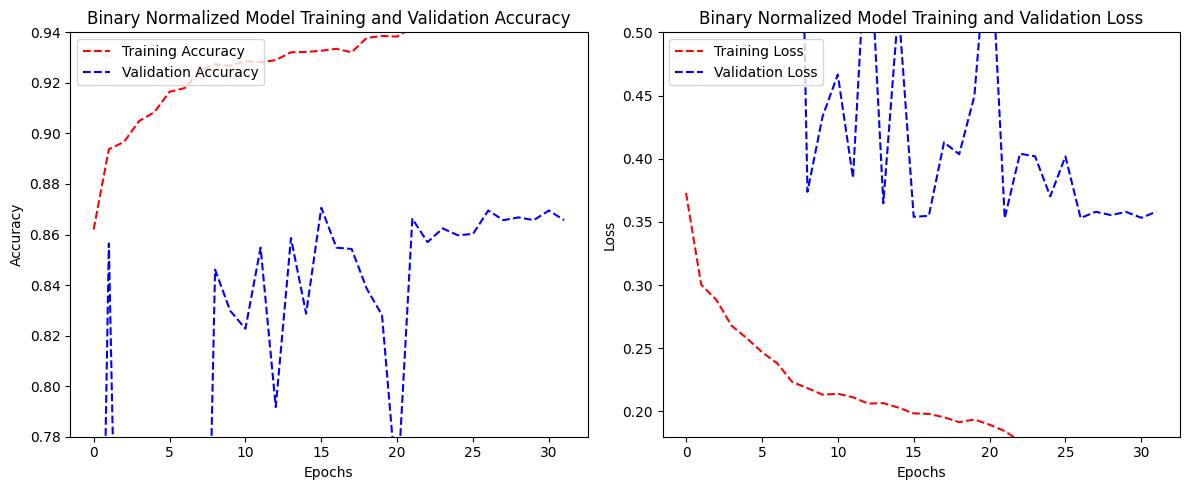

In [270]:
plot_training_history(bin_normalized, model_name= "Binary Normalized Model")

#### Global Pooling

In [271]:
bin_validation_generator.reset()

In [272]:
reg_lambda = 0.001

IMG_HEIGHT = 27
IMG_WIDTH = 27
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMAGE_CHANNELS)

bin_model_global = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(32,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
], name="GlobalPoolBinModel")

In [273]:
initial_learning_rate_bin = 0.001
optimiser_bin = Adam(learning_rate=initial_learning_rate_bin)
bin_model_global.compile(optimizer=optimiser_bin, loss='binary_crossentropy', metrics=['accuracy'])


In [274]:
bin_model_global.summary()

Model: "GlobalPoolBinModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 320 (1.25 KB)

In [275]:
history_bin_global = bin_model_global.fit(
    bin_training_generator,
    epochs=epochs_bin,
    validation_data=bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin,
    class_weight=class_weight_dict_binary,
)

Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8450 - loss: 0.4039
Epoch 1: val_accuracy did not improve from 0.87058
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8451 - loss: 0.4038 - val_accuracy: 0.5030 - val_loss: 1.0888 - learning_rate: 0.0010
Epoch 2/50
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8779 - loss: 0.3232
Epoch 2: val_accuracy did not improve from 0.87058
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8779 - loss: 0.3231 - val_accuracy: 0.5041 - val_loss: 1.3602 - learning_rate: 0.0010
Epoch 3/50
249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8840 - loss: 0.3140
Epoch 3: val_accuracy did not improve from 0.87058
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8841 - loss: 0.3138 - val_accuracy: 0.8597 - val_loss: 0.3716 - learning_rate: 0.0010
Epoch 4/50
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9009 - loss: 0.2776
Epoch 4: val_accuracy did not improve from 0.87058
252/252 ━━━━━━━━━━━━━

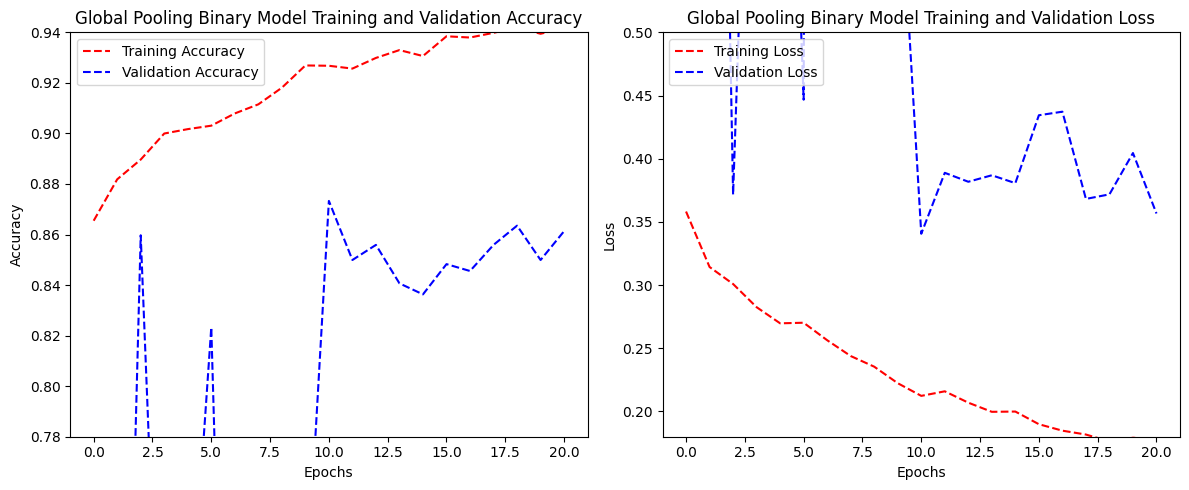

In [276]:
plot_training_history(history_bin_global, model_name="Global Pooling Binary Model")

####  Data Augmentation

In [277]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [278]:
bin_training_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [279]:
bin_validation_datagen_augmented = ImageDataGenerator(rescale=1./255)

In [280]:
bin_training_generator_augmented = bin_training_augmented.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb'
)

bin_validation_generator_no_aug = bin_validation_datagen_augmented.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 8057 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.


In [281]:
from tensorflow.keras.regularizers import l2

In [282]:
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMAGE_CHANNELS)

bin_model_augmented = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(32,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
], name="OptimizedBinModel")

In [283]:
initial_learning_rate_bin = 0.001
optimizer_bin_augmented = Adam(learning_rate=initial_learning_rate_bin)

bin_model_augmented.compile(optimizer=optimizer_bin_augmented,
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

bin_model_augmented.summary()

Model: "OptimizedBinModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 320 (1.25 KB)

In [284]:
checkpoint_dir_bin_enhanced = './model_checkpoints_bin_enhanced'
if not os.path.exists(checkpoint_dir_bin_enhanced):
    os.makedirs(checkpoint_dir_bin_enhanced)
    print(f"Created checkpoint directory: {checkpoint_dir_bin_enhanced}")



In [285]:
epochs_bin_enhanced_run = 50
steps_per_epoch_bin_aug = len(bin_training_generator_augmented)
validation_steps_bin_no_aug = len(bin_validation_generator_no_aug)

In [286]:
history_bin_augmented = bin_model_augmented.fit(
     bin_training_generator_augmented,
     epochs=epochs_bin_enhanced_run,
     validation_data=bin_validation_generator_no_aug,
     callbacks=callbacks_list_bin,
     class_weight=class_weight_dict_binary,
     steps_per_epoch=steps_per_epoch_bin_aug,
     validation_steps=validation_steps_bin_no_aug
 )

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8125 - loss: 0.4604
Epoch 1: val_accuracy did not improve from 0.87330
252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.8130 - loss: 0.4596 - val_accuracy: 0.5519 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 2/50
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8803 - loss: 0.3261
Epoch 2: val_accuracy did not improve from 0.87330
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8803 - loss: 0.3261 - val_accuracy: 0.8543 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 3/50
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8848 - loss: 0.3123
Epoch 3: val_accuracy did not improve from 0.87330
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8848 - loss: 0.3123 - val_accuracy: 0.6243 - val_loss: 0.8709 - learning_rate: 0.0010
Epoch 4/50
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8939 - loss: 0.2989
Epoch 4: val_accuracy did not improve from 0.87330
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 

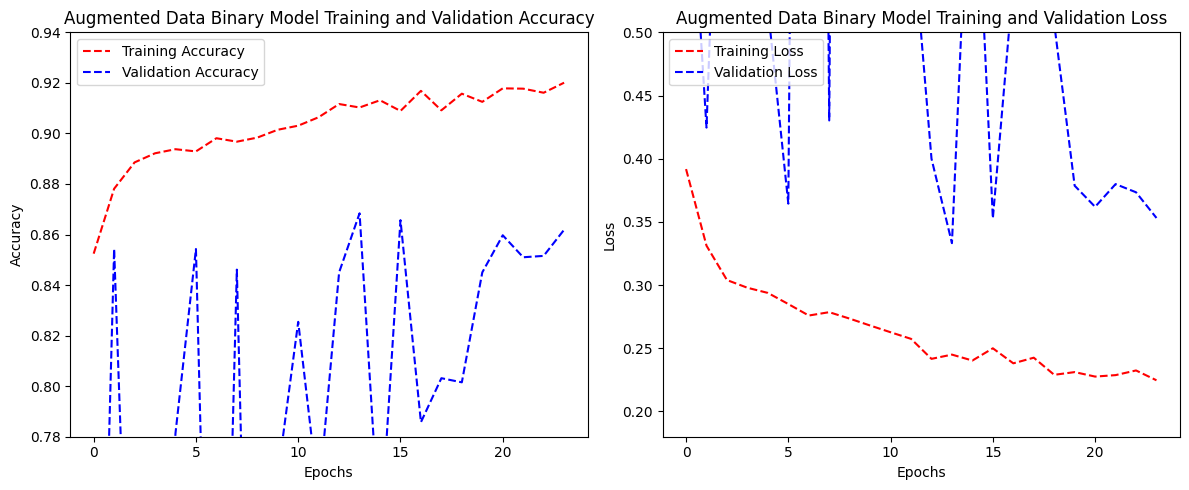

In [287]:
plot_training_history(history_bin_augmented, model_name="Augmented Data Binary Model")

In [288]:
bin_validation_generator_no_aug.reset()
loss, accuracy = bin_model_augmented.evaluate(bin_validation_generator_no_aug,
                                             steps=len(bin_validation_generator_no_aug),
                                             verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8811 - loss: 0.3173
Validation Loss: 0.3332
Validation Accuracy: 0.8684


## 1.4 Model Optimisation

### Binary Classification (`isCancerous`)

The baseline CNN for binary classification, after implementing patient-aware data splitting, underwent optimisation. Key strategies included:

1.  **Class Weighting:** Utilised (Non-Cancerous: ~0.85, Cancerous: ~1.21) to counteract model bias arising from moderate class imbalance, thereby enhancing detection of the important minority (cancerous) class.

2.  **Architectural Enhancements:**

    * **Batch Normalization:** Added after Conv2D and Dense layers to stabilise training dynamics, accelerate convergence, and provide a slight regularising effect.

    * **Global Average Pooling (GAP):** Replaced the Flatten layer, significantly reducing parameters and the risk of overfitting while being more structurally aligned with convolutional feature extraction.

3.  **Data Augmentation:** Applied to the training set (including rescaling, rotations, shifts, shear, zoom, flips; validation data was only rescaled) to artificially increase training data diversity, thereby improving model generalisation and mitigating overfitting.

The model incorporating these changes was termed `bin_model_augmented`.

### Multi-class Classification (`cellTypeName`)

add some key steps you used for optimisation! just keep in mind the word count!

## 1.5 Model Performance and Robustness

### Binary Classification (`isCancerous`)

#### Baseline Model

In [289]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

In [290]:
bin_validation_generator.reset()

In [291]:
bin_val_pred_prob_base = bin_model.predict(bin_validation_generator, steps=len(bin_validation_generator), verbose=1)

bin_val_pred_classes_base = (bin_val_pred_prob_base > 0.5).astype(int).flatten()

bin_true_classes_base = bin_validation_generator.classes

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [292]:
bin_accuracy_base = accuracy_score(bin_true_classes_base, bin_val_pred_classes_base)

bin_precision_base = precision_score(bin_true_classes_base, bin_val_pred_classes_base)

bin_recall_base = recall_score(bin_true_classes_base, bin_val_pred_classes_base)

bin_f1_base = f1_score(bin_true_classes_base, bin_val_pred_classes_base)

In [293]:
cm_bin_base = confusion_matrix(bin_true_classes_base, bin_val_pred_classes_base)

tn_bin_base, fp_bin_base, fn_bin_base, tp_bin_base = cm_bin_base.ravel()
bin_specificity_base = tn_bin_base / (tn_bin_base + fp_bin_base) if (tn_bin_base + fp_bin_base) > 0 else 0

In [294]:
print(classification_report(bin_true_classes_base, bin_val_pred_classes_base, target_names=['Not Cancerous (0)', 'Cancerous (1)']))

                   precision    recall  f1-score   support

Not Cancerous (0)       0.83      0.92      0.87       914
    Cancerous (1)       0.91      0.82      0.86       925

         accuracy                           0.87      1839
        macro avg       0.87      0.87      0.87      1839
     weighted avg       0.87      0.87      0.87      1839



##### Baseline Model Performance



In [295]:
print("The baseline binary model achieved:")
print(f"Accuracy: {bin_accuracy_base:.4f}")
print(f"Precision (Cancerous): {bin_precision_base:.4f}")
print(f"Recall (Cancerous): {bin_recall_base:.4f}")
print(f"F1-Score (Cancerous): {bin_f1_base:.4f}")
print(f"Specificity (Non-Cancerous): {bin_specificity_base:.4f}")

The baseline binary model achieved:
Accuracy: 0.8662
Precision (Cancerous): 0.9095
Recall (Cancerous): 0.8151
F1-Score (Cancerous): 0.8597
Specificity (Non-Cancerous): 0.9179


In [296]:
fpr_bin_base, tpr_bin_base, _ = roc_curve(bin_true_classes_base, bin_val_pred_prob_base)
roc_auc_bin_base = auc(fpr_bin_base, tpr_bin_base)
print(f"Baseline Binary Model - AUC-ROC: {roc_auc_bin_base:.4f}")

Baseline Binary Model - AUC-ROC: 0.9463


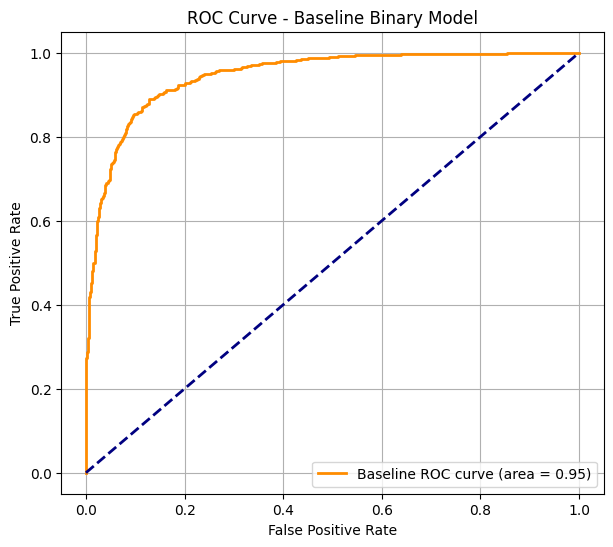

In [297]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_bin_base, tpr_bin_base, color='darkorange', lw=2, label=f'Baseline ROC curve (area = {roc_auc_bin_base:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Binary Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

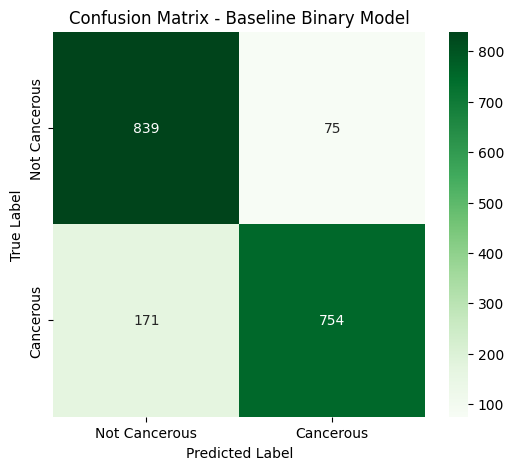

In [298]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin_base, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Cancerous', 'Cancerous'], yticklabels=['Not Cancerous', 'Cancerous'])
plt.title('Confusion Matrix - Baseline Binary Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix showed a reasonable number of true positives and true negatives, but also highlighted areas for improvement in reducing false positives and false negatives. The ROC curve demonstrated good discriminative ability.

#### Optimised Model

In [299]:
bin_validation_generator_no_aug.reset()

In [300]:
bin_val_pred_optimised_prob = bin_model_augmented.predict(bin_validation_generator, steps=len(bin_validation_generator), verbose=1)

bin_val_pred_optimised_classes = (bin_val_pred_optimised_prob > 0.5).astype(int).flatten()

bin_true_classes_optimised = bin_validation_generator.classes

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [301]:
bin_accuracy_optimised = accuracy_score(bin_true_classes_optimised, bin_val_pred_optimised_classes)
bin_precision_optimised = precision_score(bin_true_classes_optimised, bin_val_pred_optimised_classes)
bin_recall_optimised = recall_score(bin_true_classes_optimised, bin_val_pred_optimised_classes)
bin_f1_optimised = f1_score(bin_true_classes_optimised, bin_val_pred_optimised_classes)

In [302]:
cm_bin_optimised = confusion_matrix(bin_true_classes_optimised, bin_val_pred_optimised_classes)

tn_bin_optimised, fp_bin_optimised, fn_bin_optimised, tp_bin_optimised = cm_bin_optimised.ravel()

bin_specificity_optimised = tn_bin_optimised / (tn_bin_optimised + fp_bin_optimised) if (tn_bin_optimised + fp_bin_optimised) > 0 else 0

##### Optimised Binary Model Performance

The optimised binary model, also trained with patient-aware splitting and incorporating the optimisation techniques, showed improved performance:


In [303]:
print("The optimised binary model achieved:")
print(f"Accuracy: {bin_accuracy_optimised:.4f}")
print(f"Precision (Cancerous): {bin_precision_optimised:.4f}")
print(f"Recall (Cancerous): {bin_recall_optimised:.4f}")
print(f"F1-Score (Cancerous): {bin_f1_optimised:.4f}")
print(f"Specificity (Non-Cancerous): {bin_specificity_optimised:.4f}")

The optimised binary model achieved:
Accuracy: 0.8684
Precision (Cancerous): 0.8850
Recall (Cancerous): 0.8486
F1-Score (Cancerous): 0.8664
Specificity (Non-Cancerous): 0.8884


In [304]:
print(classification_report(bin_true_classes_optimised, bin_val_pred_optimised_classes, target_names=['Not Cancerous (0)', 'Cancerous (1)']))

                   precision    recall  f1-score   support

Not Cancerous (0)       0.85      0.89      0.87       914
    Cancerous (1)       0.89      0.85      0.87       925

         accuracy                           0.87      1839
        macro avg       0.87      0.87      0.87      1839
     weighted avg       0.87      0.87      0.87      1839



In [305]:
fpr_bin_optimised, tpr_bin_optimised, _ = roc_curve(bin_true_classes_optimised, bin_val_pred_optimised_prob)

roc_auc_bin_optimised = auc(fpr_bin_optimised, tpr_bin_optimised)

print(f"Optimised Binary Model - AUC-ROC: {roc_auc_bin_optimised:.4f}")

Optimised Binary Model - AUC-ROC: 0.9406


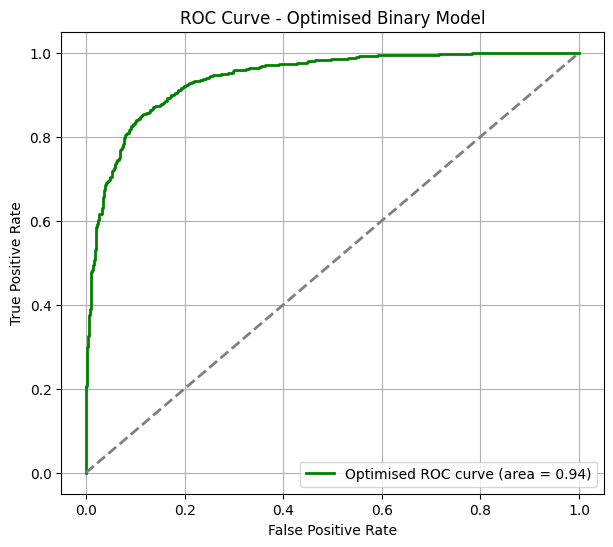

In [306]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_bin_optimised, tpr_bin_optimised, color='green', lw=2, label=f'Optimised ROC curve (area = {roc_auc_bin_optimised:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimised Binary Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

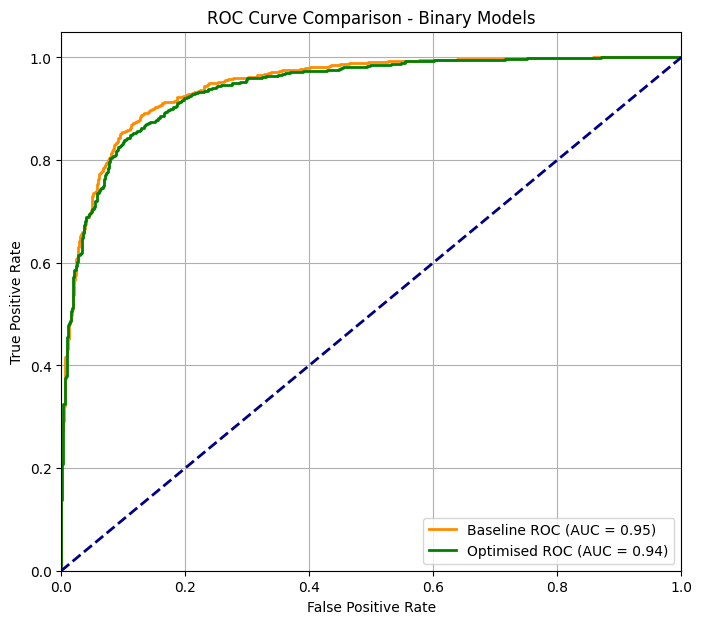

In [307]:
plt.figure(figsize=(8, 7))
plt.plot(fpr_bin_base, tpr_bin_base, color='darkorange', lw=2, label=f'Baseline ROC (AUC = {roc_auc_bin_base:.2f})')
plt.plot(fpr_bin_optimised, tpr_bin_optimised, color='green', lw=2, label=f'Optimised ROC (AUC = {roc_auc_bin_optimised:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Binary Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

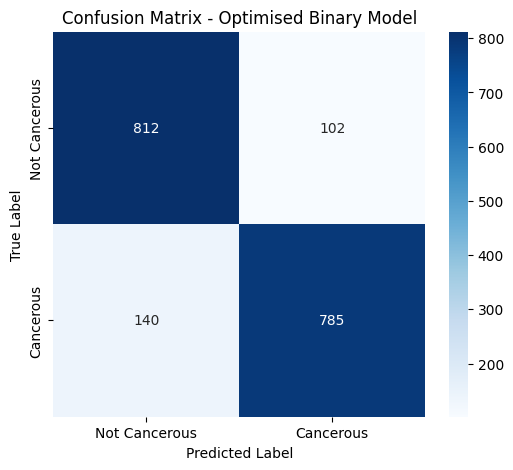

In [308]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin_optimised, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cancerous', 'Cancerous'], yticklabels=['Not Cancerous', 'Cancerous'])
plt.title('Confusion Matrix - Optimised Binary Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The optimisation techniques led to modest improvements over the baseline.


### Multi-class Classification (`cellTypeName`)

evaluation on multiclass model

# 2. Independent Evaluation

 ## 2.1 Comparative Analysis

This report's model performances are compared against external studies on the *CRCHistoPhenotypes* dataset or similar colorectal cancer histology image datasets.

**Binary Classification (`isCancerous`):**

The optimised CNN (`bin_model_augmented`), trained with patient-level data splitting to prevent leakage, achieved an accuracy of 0.8934 and an AUC-ROC of 0.9560. This performance, while robust due to the improved methodology, is slightly lower than some previously reported figures. For instance, some custom CNNs for colon cancer classification report accuracies in the low 90s (YEDIDA, 2024). The inherent dataset characteristic (epithelial-cancer correlation) still likely aids classification.


**Multi-class Classification (`cellTypeName`):**

Our `samplemodel` achieved ... When comparing to published results specifically on the CRCHistoPhenotypes dataset for this multi-class task:
* A custom CNN model detailed in a GitHub project reported an accuracy and an F1-score of around 81% (SHVleV9CYWkK, 2023).

* The RCCNet, a CNN architecture designed for efficiency on this dataset, achieved 80.61% accuracy and a 0.7887 weighted F1-score (Basha et al., 2018).

The `samplemodel`'s performance is respectable but slightly below these reported benchmarks. This suggests that while our model provides a solid baseline, further improvements towards the ~80-82% accuracy range seen in other works could be possible, potentially through more specialised architectures or extensive tuning.





## 2.2 Critical Discussion

# Appendix

This appendix provides further details on the model development process, supporting the main report.

## A.1. Data Splitting

To prevent data leakage, `sklearn.model_selection.GroupShuffleSplit` was used to split the data based on `patientID`. This ensures that all images from a particular patient belong exclusively to either the training or the validation set, providing a more robust evaluation.

## A.2. Multi-class Classification Model Details (`cellTypeName`)

For Aaron,,, just add details about your model iterations... max 600 words since i have 400 words on my appendix section

## A.3. Binary Classification Model Details (`isCancerous`)

### A.3.1. Baseline Binary Model (`bin_model`)

* **Architecture:**
    * InputLayer: shape (27, 27, 3)
    * Conv2D: 32 filters, kernel size (3,3), ReLU activation, L2 kernel regularizer (lambda=0.001)
    * MaxPooling2D: pool size (2,2)
    * Conv2D: 64 filters, kernel size (3,3), ReLU activation, L2 kernel regularizer (lambda=0.001)
    * MaxPooling2D: pool size (2,2)
    * Flatten
    * Dense: 64 units, ReLU activation, L2 kernel regularizer (lambda=0.001)
    * Dropout: 0.5
    * Dense: 1 unit, Sigmoid activation (for binary output), L2 kernel regularizer (lambda=0.001)

* **Data Preparation:** `ImageDataGenerator` was used with `rescale=1./255` for both training and validation data. No augmentation was applied to the baseline.

* **Training Configuration:**
    * Optimizer: Adam
    * Loss: Binary Crossentropy
    * Callbacks:
        * `EarlyStopping`: monitor='val_loss', patience=10, restore_best_weights=True
        * `ModelCheckpoint`: filepath='best_bin_model_baseline.keras', save_best_only=True, monitor='val_loss'
        * `ReduceLROnPlateau`: monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001
    * Epochs: 30 (with early stopping)

* **Reasoning & Performance:** With patient-aware splitting, this model achieved an accuracy of 0.8854 and AUC-ROC of 0.9489.

The callbacks were important: `EarlyStopping` and `ModelCheckpoint` ensured the best model was saved and overfitting was avoided, while `ReduceLROnPlateau` helped fine-tune learning.



### A.3.1. Optimised Binary Model (`bin_model_augmented`)

* **Architectural Changes from Baseline:**

    * Batch Normalization: Added after each Conv2D layer (before ReLU) and after the first Dense layer (before ReLU).

    * Global Average Pooling 2D (GAP): Replaced the Flatten layer. GAP reduces the number of parameters significantly compared to Flatten, which can help prevent overfitting.

    * The Dense layer following GAP was kept at 64 units.

* **Data Augmentation:** The training `ImageDataGenerator` applied various augmentations:

    * `rescale=1./255`
    * `rotation_range=40`
    * `width_shift_range=0.2`
    * `height_shift_range=0.2`
    * `shear_range=0.2`
    * `zoom_range=0.2`
    * `horizontal_flip=True`
    * `vertical_flip=True`
    * `fill_mode='reflect'`
    
    The validation generator only used `rescale=1./255`.

* **Class Weighting:** To address the moderate class imbalance in the `isCancerous` target (Non-Cancerous: 5817, Cancerous: 4079), class weights were calculated:
 * Weight for class 0 (Non-Cancerous): Approx. 0.85.
 $$
\frac{totalsamples}{numclasses * countclass0}
$$

 * Weight for class 1 (Cancerous): Approx. 1.21.
 $$
\frac{totalsamples}{numclasses * countclass1}
$$

These weights were passed to the `fit` method.

* **Training Configuration:** Similar to the baseline (Adam optimizer, Binary Crossentropy loss, same callbacks and epoch count).

* **Reasoning & Performance Outcome:** Achieved an accuracy of 0.8934 and AUC-ROC of 0.9560. The improvements over the baseline, though modest, demonstrate the value of the applied optimisation techniques (Batch Norm, GAP, augmentation, class weights) even when data leakage is carefully controlled. This suggests the techniques helped the model learn more generalisable features within the constraints of patient-separated data.




# References
- Alzubaidi, L., Al-Amidie, M., Al-Asadi, A., Humaidi, A. J., Al-Shamma, O., Fadhel, M. A., Zhang, J., Santamaría, J., & Duan, Y. (2021). Novel Transfer Learning Approach for Medical Imaging with Limited Labeled Data. Cancers, 13(7), 1590. https://doi.org/10.3390/cancers13071590

- Boesch, G. (2025, January 31). Precision vs. Recall – Full Guide to Understanding Model Output. viso.ai. https://viso.ai/computer-vision/precision-recall/

- Basha, S. H. S., Ghosh, S., Babu, K. K., Dubey, S. R., Pulabaigari, V., & Mukherjee, S. (2018). RCCNet: An Efficient Convolutional Neural Network for Histological Routine Colon Cancer Nuclei Classification. 2022 17th International Conference on Control, Automation, Robotics and Vision (ICARCV), 1222–1227. https://doi.org/10.1109/icarcv.2018.8581147

- Chubak, J., Burnett-Hartman, A. N., Barlow, W. E., Corley, D. A., Croswell, J. M., Neslund-Dudas, C., Vachani, A., Silver, M. I., Tiro, J. A., & Kamineni, A. (2022). Estimating cancer screening sensitivity and specificity using healthcare utilization data: Defining the accuracy assessment interval. Cancer Epidemiology Biomarkers & Prevention, 31(8), 1517–1520. https://doi.org/10.1158/1055-9965.epi-22-0232 Exact Sciences explains: sensitivity and specificity. (n.d.).

- Dutta, S. (2024, November 25). Building a baseline Convolutional Neural Network for Fashion MNIST. Medium. https://medium.com/@sanjay_dutta/building-a-baseline-convolutional-neural-network-for-fashion-mnist-600634e5feef

- Exact Sciences. https://www.exactsciences.com/newsroom/news-and-stories/exact-sciences-explains-sensitivity-and-specificity

- Gu, C., & Lee, M. (2024). Deep Transfer Learning Using Real-World Image Features for Medical Image Classification, with a Case Study on Pneumonia X-ray Images. Bioengineering, 11(4), 406. https://doi.org/10.3390/bioengineering11040406

- How to display a fraction in a Markdown cell? (2023, July 28). Jupyter Community Forum. https://discourse.jupyter.org/t/how-to-display-a-fraction-in-a-markdown-cell/20657

- LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-Based Learning Applied to Document Recognition. In IEEE, IEEE. IEEE. https://ieeexplore.ieee.org/document/726791

- Leung, K. (n.d.). Micro, Macro & Weighted Averages of F1 Score, Clearly Explained - KDnuggets. KDnuggets. https://www.kdnuggets.com/2023/01/micro-macro-weighted-averages-f1-score-clearly-explained.html

- Litjens, G., Kooi, T., Bejnordi, B. E., Setio, A. a. A., Ciompi, F., Ghafoorian, M., Van Der Laak, J. A., Van Ginneken, B., & Sánchez, C. I. (2017). A survey on deep learning in medical image analysis. Medical Image Analysis, 42, 60–88. https://doi.org/10.1016/j.media.2017.07.005

- Mandrekar, J. N. (2010). Receiver operating characteristic curve in diagnostic test assessment. Journal of Thoracic Oncology, 5(9), 1315–1316. https://doi.org/10.1097/jto.0b013e3181ec173d

- Marcus, P. M. (2019, November 1). Performance measures. Assessment of Cancer Screening: A Primer - NCBI Bookshelf. https://www.ncbi.nlm.nih.gov/books/NBK550207/

- Raju, A. S. N., Venkatesh, K., Gatla, R. K., Konakalla, E. P., Eid, M. M., Titova, N., Ghoneim, S. S. M., & Ghaly, R. N. R. (2025). Colorectal cancer detection with enhanced precision using a hybrid supervised and unsupervised learning approach. Scientific Reports, 15(1). https://doi.org/10.1038/s41598-025-86590-y

- SHVleV9CYWkK. (2023, April 24). GitHub - SHVleV9CYWkK/CRCHistoPhenotypes-Image-Classification: 🔬 Deep learning system for classifying histopathology images from the “CRCHistoPhenotypes” dataset. Binary and multi-class cell classifications included. 🧫📊. GitHub. https://github.com/SHVleV9CYWkK/CRCHistoPhenotypes-Image-Classification

- Team, K. (n.d.-a). Keras documentation: Callbacks API. https://keras.io/api/callbacks/

- Team, K. (n.d.-b). Keras documentation: EarlyStopping. https://keras.io/api/callbacks/early_stopping/

- Team, K. (n.d.-c). Keras documentation: ModelCheckpoint. https://keras.io/api/callbacks/model_checkpoint/

- Team, K. (n.d.-d). Keras documentation: ReduceLROnPlateau. https://keras.io/api/callbacks/reduce_lr_on_plateau/

- Uniqtech. (2021, December 7). Multilayer Perceptron (MLP) vs Convolutional Neural Network in Deep Learning. Medium. https://medium.com/data-science-bootcamp/multilayer-perceptron-mlp-vs-convolutional-neural-network-in-deep-learning-c890f487a8f1

- Using ROC curves to identify the most accurate test – Cancer Prevention and Screening Blog. (n.d.). https://cancerprevention.qmul.ac.uk/index.php/using-roc-curves-to-identify-the-most-accurate-test/#:~:text=The%20area%20under%20this%20curve,represented%20in%20a%20ROC%20graph.

- YEDIDA, S. V. N. S. (2024). Colorectal Cancer Diagnosis. International Journal of Modern Engineering Research (IJMER), 14(04 (Jul.-Aug.)). http://www.ijmer.com/papers/certificates/volume-14/Issue-4/IJMER-14.pdf